# Tuft processing

Having processed the wing image to obtain tuft sub-images, we are now interested in processing these sub-images delicately to obtain 0-1 matrices usable by our chosen machine learning technique.

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy import ndimage
from scipy.signal import convolve2d
from PIL import Image

from tuft_helpers import *

In [2]:
# Load the processed data into pandas
tufts_df = load_df('im0007')

46


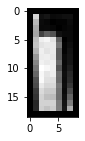

In [3]:
# Check to see that tuft images are correctly loaded

import random as rand
from basic import rescale_image

i = rand.randint(0, len(tufts_df['tuft']) - 1)
print(i)

img = np.array(tufts_df.iloc[i]['tuft'])

plt.figure(figsize=(2, 2))
plt.imshow(rescale_image(img), cmap='gray')

We observe that the tufts we seek to extract and process are always attached to the bottom of the image. Our first approach to isolating the tuft is the following:
- Find the brightest pixel close to the center on the bottom-most row of the image (taking into account the black border).
- From this pixel, construct a blob such that all pixels have similar brightness values (the difference between two adjacent blobs does not exceed a threshold value $delta$)
- The blob constitutes the tuft. All its pixels are to be colored white (set to 1), and all other pixels in the image are to be colored black (set to 0).

In [4]:
def mid_generator(width):
    mid = int(np.floor(width / 2))
    lo = list(range(mid))
    lo.reverse()
    hi = list(range(mid, width))

    i = 0
    while (lo or hi):
        i = (i + 1) % 2
        if (i == 0):
            y = lo[0]
            lo = lo[1:]
        else:
            y = hi[0]
            hi = hi[1:]

        yield y

In [5]:
def get_lower_brightest_pixel(img, bg_threshold):

    for i in range(img.shape[0] - 1).__reversed__():
        width = len(img[i])
        for j in mid_generator(width):
            if (img[i, j] > bg_threshold):
                return (i, j)

    return None


In [6]:
start_pixel = get_lower_brightest_pixel(img, 0.2)
print(start_pixel)

(17, 4)


In [7]:
from blobs import get_blob_pixels, coordinates_within_bounds, index_set

In [8]:
sim_delta = 0.025

def pixel_is_similar(img, cur_, next_):
    """
    Check that the next pixel is within image
    boundaries and has a value similar enough to
    the current pixel.
    """
    return coordinates_within_bounds(img, next_)\
           and (np.abs(img[cur_] - img[next_]) <= sim_delta)

In [9]:
main_blob = get_blob_pixels(img, start_pixel, pixel_is_similar, set())


idx = index_set(main_blob)


result_img = np.zeros(shape=img.shape)
result_img[idx] = 1

In [10]:
def show_several(imgs, grid_size=None, img_size=None, cmap='viridis'):

    if (grid_size == None):
        grid_size = (1, len(imgs))
    if (img_size == None):
        img_size = (6, len(imgs) * 6)

    fig = plt.figure(figsize=img_size)
    rows, columns = grid_size
    for i in range(1, columns*rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i - 1], cmap=cmap)
    plt.show()


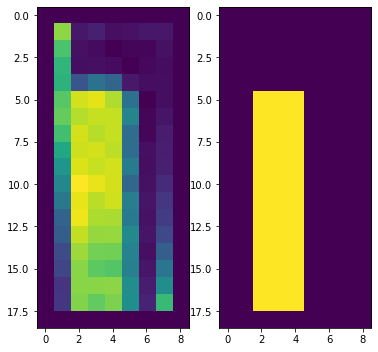

In [11]:
show_several([img, result_img])

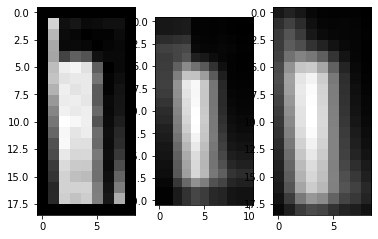

In [12]:
# Second approach: attempt edge detection on the tuft sub-image
from scipy.signal import convolve2d

sobel = [
    [-3-3j, 0-10j, 3-3j],
    [-10+0j, 0+0j, 10+0j],
    [-3+3j, 0+10j, 3+3j]
]

scharr = [
    [-47-47j, 0-162j, 47-47j],
    [-162-0j, 0-0j, 162-0j],
    [-47+47j, 0+162j, 47+47j]
]

box = np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]
]) * 1/9

conv_img = np.absolute(convolve2d(img, box, mode='full', boundary='symm'))
show_several([img, conv_img, ndimage.filters.gaussian_filter(img, 1)], cmap='gray')

In [13]:
def apply_conv_op(img, op):
    result_img = img.copy()
    result_img = np.absolute(convolve2d(result_img, op, mode='full', boundary='symm'))
    return result_img

In [14]:
def find_closest_point(pt, idx):
    c_x, c_y = pt

    min_dist = np.inf
    min_idx = -1
    for i in range(len(idx[0])):
        x, y = (idx[0][i], idx[1][i])
        dist = np.sqrt(((x - c_x) ** 2) + ((y - c_y) ** 2))
        if (dist < min_dist):
            min_dist = dist
            min_idx = i

    return (idx[0][min_idx], idx[1][min_idx])


In [15]:
from blobs import get_blob_pixels, coordinates_within_bounds, index_set, always_true_validator


In [16]:
from scipy.ndimage.filters import maximum_filter, minimum_filter

In [17]:
from basic import separate

def tuft_pipeline(img):

    result_img = img.copy()

    #separate(result_img, 0)
    #result_img = np.log10(result_img, where=result_img != 0)

    return get_tuft_blob(result_img)


In [18]:
def naive_line(r0, c0, r1, c1):
    # The algorithm below works fine if c1 >= c0 and c1-c0 >= abs(r1-r0).
    # If either of these cases are violated, do some switches.
    if abs(c1-c0) < abs(r1-r0):
        # Switch x and y, and switch again when returning.
        xx, yy, val = naive_line(c0, r0, c1, r1)
        return (yy, xx, val)

    # At this point we know that the distance in columns (x) is greater
    # than that in rows (y). Possibly one more switch if c0 > c1.
    if c0 > c1:
        return naive_line(r1, c1, r0, c0)

    # We write y as a function of x, because the slope is always <= 1
    # (in absolute value)
    x = np.arange(c0, c1+1, dtype=float)
    y = x * (r1-r0) / (c1-c0) + (c1*r0-c0*r1) / (c1-c0)

    valbot = np.floor(y)-y+1
    valtop = y-np.floor(y)

    return (np.concatenate((np.floor(y), np.floor(y)+1)).astype(int), np.concatenate((x, x)).astype(int),
            np.concatenate((valbot, valtop)))


In [21]:
def get_tuft_blob(img):
    or_img = img.copy()[1:-1, 1:-1]
    img = rescale_image(img[1:-1, 1:-1])


    img = ndimage.filters.gaussian_filter(img, 1.25)


    footprint = int(np.floor(img.shape[0]/2))

    maxima = (img == maximum_filter(img, footprint)).astype(np.float16)
    max_idx = np.where(maxima == 1.0)

    minima = (img == minimum_filter(img, footprint)).astype(np.float16)
    min_idx = np.where(minima == 1.0)

    closest = find_closest_point((img.shape[0]/2, img.shape[1]/2), max_idx)


    bottom_mid = (img.shape[0] - 1, int(np.floor(img.shape[1] / 2)))


    line_img = np.zeros(img.shape)
    xx, yy, val = naive_line(
        closest[0], closest[1], bottom_mid[0], bottom_mid[1])

    l = len(xx)
    #xx, yy = xx[:l], yy[:l]
    #xx -= 1
    #yy -= 1
    #print(xx)
    
    xx = [x for x in xx if x > 0 and x < line_img.shape[0]]
    yy = [y for y in yy if y > 0 and y < line_img.shape[1]]
            

    line_img[xx, yy] = 1



    #brighten the area
    img[np.where(line_img == 1)] = np.max(val)#1#img + line_img * 0.05
    img = rescale_image(img)
    plt.imshow(img)




    inv_img = 1 - img#separate(1 - img, 10)
    inv_img = (inv_img * (10 ** 3)).astype(np.uint16)

    mask = np.zeros(shape=inv_img.shape, dtype=bool)
    mask[max_idx] = True
    mask[min_idx] = True

    markers, _ = ndimage.label(mask)

    labels = ndimage.watershed_ift(inv_img, markers)

    result = labels.copy()

    zones = list(np.unique(markers))

    zones.remove(markers[closest])

    for l in zones:
        result[np.where(labels == l)] = 0

    result[np.where(labels == markers[closest])] = 1


    frame = (33, 12)

    crop = np.zeros(shape=frame)
    crop[-result.shape[0]:frame[0], -result.shape[1]:frame[1]] = result
    result = crop

    show_several([or_img, img, markers, labels, result, line_img])

    return labels


In [22]:
import random as rand
from basic import rescale_image


tufts_df = load_df('im0009')
#shapes = set()
#for i, tuft in tufts_df.iterrows():
#    shapes.add(np.array(tuft['tuft']).shape)

i = rand.randint(0, len(tufts_df['tuft']) - 1)
i = 354
print(i)
#i=497

img = np.array(tufts_df.iloc[i]['tuft'])
result_img = tuft_pipeline(img)

# 101, 277, 300, 506, 244


354


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (46,) (45,) 